In [108]:
%pylab inline
from matplotlib import pylab as plt

Populating the interactive namespace from numpy and matplotlib


In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne 

## Infinite factor model

We have the following matrix factor model:

$$X = UV^T + \epsilon$$

for $U$ an $N\times K$ matrix and $V$ a $P\times K$ matrix, and $\epsilon_{i,j}\sim N(0,s)$. We use the following prior:

$$U_{ij} \sim N\left(0,\left(\gamma_{ij}\prod_{\ell=1}^j \delta_\ell\right)^{-1}\right)$$
$$V_{ij}\sim N(0,1)$$
$$\gamma_{ij} \sim \text{Gamma}(1/2,1/2)$$
$$\delta_1 \sim \text{Gamma}(a_1,1)$$
$$\delta_\ell \sim \text{Gamma}(a_2,1) \quad \ell\geq 2$$
$$a_1 \sim \text{Gamma}(1,b)$$
$$a_2 \sim \text{Gamma}(1,b)$$
$$s \sim \text{Exp}(1).$$

Our variational approximation $q$ of the posterior $p$ makes the rows of $U$ and $V$ independent multivariate normals, and all the other parameters, which are strictly positive, independent and log-normal. We call the variational parameters collectively $\lambda$.

The Evidence Lower Bound (ELBO) is

$$\mathcal L(\lambda) = E_q(\log p) - E_q(\log q) = E_q(\log p) + H(q). $$

We have 

$$H(q) = C + \sum_{i=1}^N \frac{1}{2}\log |\Sigma_{U_i}| + \sum_{j=1}^P \frac{1}{2}\log |\Sigma_{V_j}| 
          + \sum_{\ell=1}^K \sum_{i=1}^N \log(\sigma_{\gamma_{i \ell}}) + \mu_{\gamma_{i \ell}} 
          + \sum_{\ell=1}^K \log(\sigma_{\delta_\ell}) + \mu_{\delta_\ell} 
          + \log(\sigma_{a_1}) + \mu_{a_1}
          + \log(\sigma_{a_2}) + \mu_{a_2}
          + \log(\sigma_{s}) + \mu_{s}
$$         

where $C$ collects constants that do not depend on the variational parameters. Now,

$$\nabla_\lambda \mathcal L(\lambda) = \nabla_\lambda E_q(\log p) + \nabla_\lambda H(q). $$

Let all the normal parameters be transforms of a standard normal variate, e.g. $U_i = \mu_{U_i} + \Sigma_{U_i}^{1/2}Z_{U_i}$, or $\log(\delta_\ell) = \mu_{\delta_\ell} + \sigma_{\delta_\ell}z_{\delta_\ell}$, and let $E$ denote the expectation with respect to these standard variates. The first term in the gradient can be written 

$$ \nabla_\lambda E_q(\log p) = E( \nabla_\lambda \log p ),$$

where on the right hand side, we take the expectation with respect to the standard variates and write $\log p$ as a function of the variational parameters:

$$ \log p = - \frac{1}{2s}\| X-UV^T \|^2 - \frac{N\times P}{2}\log s - s
            - \frac{1}{2}\sum_{i=1}^n\sum_{j = 1}^k  U_{ij}^2\gamma_{ij}\prod_{\ell=1}^j \delta_\ell
            - \frac{1}{2}\sum_{i=1}^p\sum_{j = 1}^k  V_{ij}^2 \qquad \qquad \qquad  \qquad \qquad \qquad  \qquad $$
$$          - b a_1 - b a_2 -\frac{1}{2}\sum_{i\leq N, j\leq P} \left( \log \gamma_{ij} - \gamma_{ij}\right)
            - \log\Gamma(a_1) + (a_1-1)\log\delta_1 -\delta_1 
            + \sum_{1<\ell\leq K}\left( \log\Gamma(a_2) +(a_2-1) \log\delta_\ell -\delta_\ell \right).
$$

The expectation of the gradient of the log posterior will be estimated using a single sample of the standard variates.

In [98]:
# Syntactic sugar for shared variable
Shared = lambda shape,name: theano.shared(value = np.ones(shape,dtype=theano.config.floatX),
                                          name=name,borrow=True) 

# Define dimensions
N = 50
P = 100
K = 10

# Read data. In this example, X = 1 . 1^T, a rank 1 matrix 
X = theano.shared(np.ones((N,P),dtype=theano.config.floatX))

# Define variational parameters
mU = Shared((N,K),"mU")
mV = Shared((P,K),"mV")
sU = Shared((N,K,K),"sU")                     # Factors for covariance 
sV = Shared((P,K,K),"sV")                     # matrices of rows of U and V
sU.set_value([np.eye(K) for i in range(N)])
sV.set_value([np.eye(K) for i in range(P)])
mDelta = Shared((K),"mDelta")
sDelta = Shared((K),"sDelta")
mGamma = Shared((N,K),"mGamma")
sGamma = Shared((N,K),"sGamma")
ma1 = Shared((1),"ma1")
sa1 = Shared((1),"sa1")
ma2 = Shared((1),"ma2")
sa2 = Shared((1),"sa2")
ms = Shared((1),"ms")
ss = Shared((1),"ss")

# Define a stream of random numbers
srng = T.shared_randomstreams.RandomStreams(seed=234)

# Define model parameters 
## Standard versions:
zU = srng.normal((N,K))
zV = srng.normal((P,K))
zGamma = srng.normal((N,K))
zDelta = srng.normal([K])
za1 = srng.normal([1])
za2 = srng.normal([1])
zs = srng.normal([1])
## Non-standard versions:
U = mU+T.batched_dot(zU,sU) 
V = mV+T.batched_dot(zV,sV)
Gamma = T.exp(mGamma + sGamma*zGamma)   # The variables Gamma, Delta,
Delta = T.exp(mDelta + sDelta*zDelta)   # a1, a2, and s have a log-normal
a1 = T.exp(ma1 + sa1*za1)               # variational posterior
a2 = T.exp(ma2 + sa2*za2)
s = T.exp(ms + ss*zs)

# Define lists
vParams = [mU,mV,sU,sV,mDelta,sDelta,mGamma,sGamma,ma1,sa1,ma2,sa2,ms,ss]
mParams = [U,V,Gamma,Delta,a1,a2,s]
            
def Entropy(N,P,K,vParams):
    """
    Defines entropy of variational posterior (up to a constant)
    """
    mU,mV,sU,sV,mDelta,sDelta,mGamma,sGamma,ma1,sa1,ma2,sa2,ms,ss = vParams
    outputs, updates = theano.scan(lambda i,y: T.log(T.nlinalg.Det()(T.dot(sU[i,:,:].T,sU[i,:,:])))/2+y,
                                   sequences = [dict(input=np.arange(N) ,taps=[-1])], 
                                   outputs_info = [dict(initial= np.float64(0) ,taps=[-1])] )
    outputs, updates = theano.scan(lambda i,y: T.log(T.nlinalg.Det()(T.dot(sV[i,:,:].T,sV[i,:,:])))/2+y,
                                   sequences = [dict(input=np.arange(P) ,taps=[-1])], 
                                   outputs_info = [dict(initial= outputs[-1] ,taps=[-1])] )
    ent = outputs[-1]
    ent += T.log(sGamma).sum() + mGamma.sum() \
          + T.log(sDelta).sum() + mDelta.sum() \
          + T.log(T.abs_(sa1)) + ma1 + T.log(T.abs_(sa2)) + ma2  + T.log(T.abs_(ss)) + ms
    return(ent)
        
def LogP(N,P,K,X,mParams,vParams):
    """
    Defines the log posterior (up to a constant)
    """
    mU,mV,sU,sV,mDelta,sDelta,mGamma,sGamma,ma1,sa1,ma2,sa2,ms,ss = vParams
    U,V,Gamma,Delta,a1,a2,s = mParams
    b = 1
    logP = - T.sqr(X-T.dot(U,V.T)).sum()/(2*s) - (N*P)*T.log(s)/2 - s \
           - (T.sqr(U)*Delta.cumprod()*Gamma).sum()/2 \
           + T.log(Delta.cumprod()*Gamma).sum()/2 \
           - (T.sqr(V)).sum()/2 \
           - b*a1 - b*a2 - T.log(Gamma).sum()/2 - Gamma.sum()/2 \
           - T.gammaln(a1) + (a1-1)*T.log(Delta[0]) - Delta[0] \
           - T.gammaln(a2)*(K-1) + (a2-1)*T.log(Delta[1:]).sum() - Delta[1:].sum()
    return(logP)
            
def ELBO(N,P,K,X,mParams,vParams):
    return(LogP(N,P,K,X,mParams,vParams)[0]+Entropy(N,P,K,vParams)[0])

In [99]:
# Lasagne does gradient descent, so the cost we minimize is the *negative* ELBO 
elbo = ELBO(N,P,K,X,mParams,vParams)
vParamUpdates = lasagne.updates.adadelta(-elbo,vParams)
AdaDeltaStep = theano.function(inputs=[],updates=vParamUpdates)

In [100]:
%%time
counter = 0
ELBOlist = []
keepUpdating = True
while keepUpdating:
    
    AdaDeltaStep()
    
    # Estimate ELBO by Monte Carlo every 20 steps
    if counter%20==0:
        ELBOlist.append(np.mean([elbo.eval() for i in range(10)]))
    
    keepUpdating = False if counter>10000 else True
    counter += 1

CPU times: user 2min 13s, sys: 327 ms, total: 2min 14s
Wall time: 2min 16s


In [101]:
# This is the posterior mean of Delta
np.exp(mDelta.eval()+sDelta.eval()**2/2)

array([  2.92449594,  13.86861627,  13.59180294,   3.00357889,
         1.25214395,   1.00966683,   0.55688106,   0.14132028,
         0.06794428,   0.37358799])

In [102]:
# The mean of X is close to the true X
np.dot(mU.eval(),mV.eval().T)

array([[ 1.00547908,  0.99674156,  1.00389294, ...,  1.00889308,
         1.01246196,  1.00522474],
       [ 0.98208853,  0.97358375,  0.97994651, ...,  0.98648441,
         0.98958104,  0.98312399],
       [ 1.00115643,  0.99253686,  0.99968575, ...,  1.00452786,
         1.00847194,  1.00088442],
       ..., 
       [ 1.00589885,  0.99682222,  1.00417996, ...,  1.00970723,
         1.01304432,  1.00565088],
       [ 1.00209112,  0.9930589 ,  1.00005166, ...,  1.00604774,
         1.00931716,  1.00244517],
       [ 1.00171167,  0.99343292,  1.00027839, ...,  1.00541091,
         1.00893671,  1.00157931]])

In [103]:
# And the factors reveal the rank 1 structure 
mU.eval()

array([[  7.94301186e-01,   5.72235048e-02,   5.82947455e-03,
         -2.29265841e-03,  -5.83465797e-03,   5.99840913e-03,
          4.90185997e-03,  -9.24372040e-03,   2.68378937e-01,
          3.97440531e-01],
       [  7.93884182e-01,   6.94057272e-02,   9.00190629e-03,
          1.47546966e-02,   5.62426935e-03,   4.31587614e-03,
         -1.33005805e-02,   1.96299635e-02,   2.28277699e-01,
          3.63479407e-01],
       [  7.93769985e-01,   7.02733447e-02,  -2.91196702e-03,
          1.14556478e-03,   3.08463722e-03,  -1.84153390e-04,
          1.65588829e-03,  -2.32088959e-02,   2.66693597e-01,
          3.88909851e-01],
       [  7.87522399e-01,   5.32447775e-02,  -4.69861907e-03,
          9.16873388e-03,   4.90541173e-03,  -4.08980285e-03,
         -4.58870727e-03,   5.91316733e-03,   2.51193907e-01,
          3.93487883e-01],
       [  7.98551835e-01,   5.88126009e-02,  -2.56353967e-03,
         -6.15134359e-03,   5.20285957e-03,   5.65415665e-03,
          7.51233081e-03

In [104]:
mV.eval()

array([[  9.94868280e-01,  -1.71046997e-02,   2.11079687e-02,
         -8.30275338e-03,  -4.35570549e-03,  -2.14175329e-02,
         -2.43777346e-02,  -1.50692332e-03,   2.67724413e-01,
          3.63444975e-01],
       [  9.94664841e-01,   9.68672754e-03,  -1.31803226e-02,
         -1.01560570e-02,  -4.21931851e-02,   1.44564886e-03,
          1.85862392e-02,   3.25116833e-03,   2.51913761e-01,
          3.47858538e-01],
       [  9.97565872e-01,  -1.05309500e-02,   4.97901951e-04,
         -3.23112145e-02,  -1.11461950e-03,  -3.72301986e-05,
          3.09062089e-03,  -5.17151040e-03,   2.63326373e-01,
          3.55550889e-01],
       [  9.95280229e-01,  -1.63348474e-02,   1.75320078e-02,
         -1.63381242e-03,   1.64061660e-02,  -1.94488928e-02,
          1.97143247e-02,  -1.85286211e-02,   2.45231650e-01,
          3.44608984e-01],
       [  1.00054424e+00,  -1.85584612e-02,  -2.00876043e-02,
         -3.90790940e-02,  -6.44265158e-03,   8.62852774e-03,
         -8.57529732e-03

In [105]:
# We can check that the variance s of the noise in X is small
s.eval()

array([ 0.00115952])

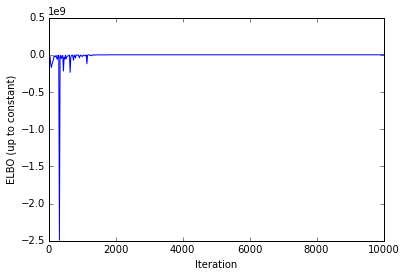

In [117]:
# Finally, we plot the ELBO against iteration
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0,10001,20),ELBOlist)
ax.set_xlabel("Iteration")
ax.set_ylabel("ELBO (up to constant)")

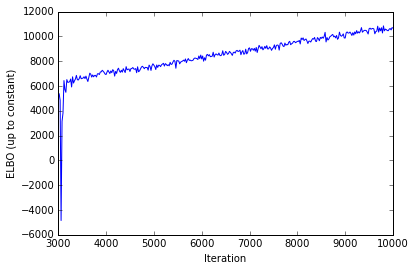

In [118]:
# Zooming into the last ~7000 iterations
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0,10001,20)[-7000/20:],ELBOlist[-7000/20:])
ax.set_xlabel("Iteration")
ax.set_ylabel("ELBO (up to constant)")